In [29]:
import ee, geemap, geopandas as gpd
import matplotlib.pyplot as plt , seaborn as sns
from math import ceil
from shapely.geometry import Polygon
import os
ee.Initialize()

<AxesSubplot:>

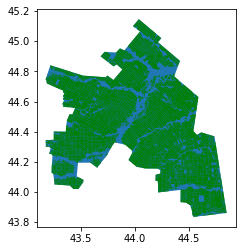

In [20]:
fields = gpd.read_file('vector/cliped_by_Region_agriculture_mask_fields.geojson')
mask = gpd.read_file('vector/Region_agriculture_mask.geojson')

fig, ax = plt.subplots(1, 1)

mask.plot(ax = ax)
fields.plot(color = 'g', ax = ax)



In [37]:
def Get_sentinel_raster(mask):
    batch_download_dir = "raster/batch_download"
    #os.mkdir("batch_download_dir") потом допилю с try
    mosaic, mosaic_crs = get_gee_mosaic(mask)
    name_list = batch_download(mask,mosaic,batch_download_dir )
    build_local_mosaic(name_list, batch_download_dir)
    
    

In [36]:
def get_gee_mosaic(mask, first_date = '2021-05-01', last_date = '2021-09-30'):
    '''на вход геометрия маски по которой искать и обрезать + необязательно даты
        на выход изображение и сиситема координат
    '''
    collection = ee.ImageCollection('COPERNICUS/S2_SR') \
                    .filterDate('2021-05-01', '2021-09-30') \
                    .filterBounds(geemap.geopandas_to_ee(mask)) \
                    .filterMetadata("CLOUD_COVERAGE_ASSESSMENT", 'less_than', 0.1) \
                    .sort("system:time_start") \
            

    crs = collection.first().select('B1').projection().getInfo()['crs']
    scale = 10 

    collection_median = collection.median().reproject(crs = crs,scale = scale)
    collection_median = collection_median.clip(geemap.geopandas_to_ee(mask).geometry())
    collection_median = collection_median.select(['B4','B3','B2',"B8"])

    return(collection_median, crs)
def batch_download(mask,mosaic, batch_download_dir,step = 0.15 ):
    """
    input
    mask - геометрия
    mosaic - мозайка GEE которую выкачивать
    batch_download_dir - директория куда выкачиваются батчи
    step = размер батча в градусах


    output
    batches_dir_list - лист с названиями выкаченных батчей
    """
    MinMax_coords = mask.total_bounds  #получение крайних точек
    lat_ = MinMax_coords[2] - MinMax_coords[0] # расстояния между крайними точками в градусах 
    lon_ = MinMax_coords[3] - MinMax_coords[1] # расстояния между крайними точками в градусах 
    step = 0.15 #шаг окна

    lat_range = ceil(lat_/step)
    lon_range = ceil(lon_/step)

    for y_step,y in enumerate(range(lon_range)): #lon_range
        bottom_left_angle = [MinMax_coords[0],MinMax_coords[1]+(step * y)] #точка начала отчета левый нижний угол каждую итерацию Y поднимается вверх на y
        for x_step, x in enumerate(range(lat_range)): #lat_range
            bottom_left_angle = bottom_left_angle 
            top_left_angle = [bottom_left_angle[0] ,bottom_left_angle[1] +  step] 
            top_right_angle = [bottom_left_angle[0] + step ,bottom_left_angle[1] + step]
            bottom_right_angle = [bottom_left_angle[0] + step ,bottom_left_angle[1] ] 

            file_name = "{}_{}.tif".format(y_step,x_step)

            poly = Polygon([bottom_left_angle,top_left_angle,  top_right_angle,bottom_right_angle,])
            poly = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[poly])

            file_name = "{}_{}.tif".format(y_step,x_step)


            cliped = mosaic.clip(geemap.geopandas_to_ee(poly).geometry()).float() #попытка снизить размерность
            
        
            
            bottom_left_angle = bottom_right_angle
            geemap.ee_export_image(cliped, 
                                    filename=batch_download_dir + "/"+file_name,
                                    scale = 10,
                                    file_per_band=False)
    batches_names_list = os.listdir('raster/batch_download') #вот она ошибка надо править((((
    return(batches_names_list)
    
def build_local_mosaic(batches_names_list, batch_download_dir):
    rasters = []
    for dir in batches_names_list:
        raster = rasterio.open(batch_download_dir + '/' + dir) 
        rasters.append(raster)


    mosaic, out_trans = merge(rasters)
    metadata = raster.meta.copy() #метаданные из любого батча который мы вынимаем 
    metadata.update({"height": mosaic.shape[1],
                        "width": mosaic.shape[2],
                        "transform": out_trans})
    with rasterio.open('raster/train__data_raster.tif', "w", **metadata) as dest:
        dest.write(mosaic)
    print("удачно")
    

            






In [38]:
Get_sentinel_raster(mask)

Generating URL ...
An error occurred while downloading.
Image.clipToBoundsAndScale: The geometry for image clipping must not be empty.
Generating URL ...
An error occurred while downloading.
Image.clipToBoundsAndScale: The geometry for image clipping must not be empty.
Generating URL ...
An error occurred while downloading.
Image.clipToBoundsAndScale: The geometry for image clipping must not be empty.
Generating URL ...
An error occurred while downloading.
Image.clipToBoundsAndScale: The geometry for image clipping must not be empty.
Generating URL ...
An error occurred while downloading.
Image.clipToBoundsAndScale: The geometry for image clipping must not be empty.
Generating URL ...
An error occurred while downloading.
Image.clipToBoundsAndScale: The geometry for image clipping must not be empty.
Generating URL ...
An error occurred while downloading.
Image.clipToBoundsAndScale: The geometry for image clipping must not be empty.
Generating URL ...
An error occurred while downloading.

RasterioIOError: raster/batch_download/1_2.tif.aux.xml: No such file or directory

In [42]:

batches_names_list = os.listdir('raster/batch_download')
build_local_mosaic(batches_names_list,'raster/batch_download' )

 

удачно


Generating URL ...
An error occurred while downloading.
Image.clipToBoundsAndScale: The geometry for image clipping must not be empty.
Generating URL ...
An error occurred while downloading.
Image.clipToBoundsAndScale: The geometry for image clipping must not be empty.
Generating URL ...
An error occurred while downloading.
Image.clipToBoundsAndScale: The geometry for image clipping must not be empty.
Generating URL ...
Please wait ...
Data downloaded to d:\python_projects\regional_scale\raster\batch_down_load\1_0.tif
Generating URL ...
Please wait ...
Data downloaded to d:\python_projects\regional_scale\raster\batch_down_load\1_1.tif
Generating URL ...
Please wait ...
Data downloaded to d:\python_projects\regional_scale\raster\batch_down_load\1_2.tif
Generating URL ...
Please wait ...
Data downloaded to d:\python_projects\regional_scale\raster\batch_down_load\2_0.tif
Generating URL ...
Please wait ...
Data downloaded to d:\python_projects\regional_scale\raster\batch_down_load\2_1.tif


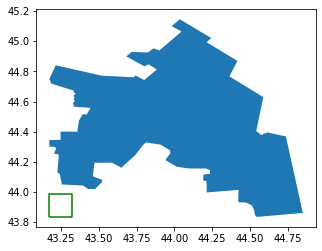

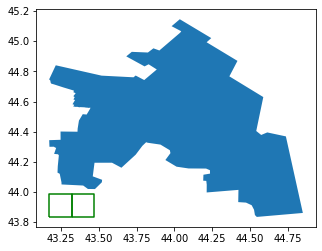

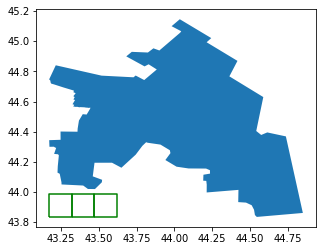

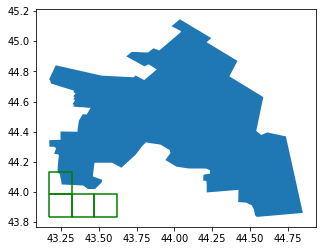

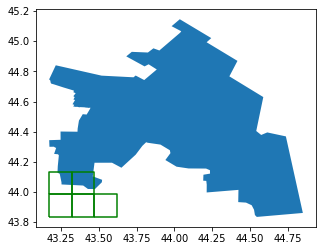

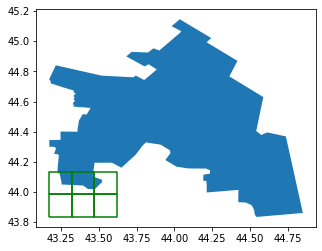

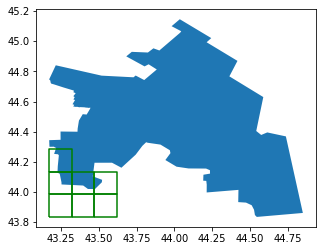

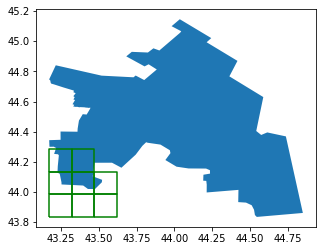

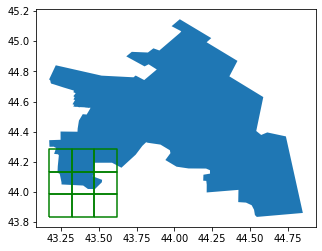

In [32]:
from math import ceil
from shapely.geometry import Polygon
 
step = 0.15 #шаг окна

lat_range = ceil(lat_/step)
lon_range = ceil(lon_/step)

for y_step,y in enumerate(range(3)): #lon_range
    bottom_left_angle = [MinMax_coords[0],MinMax_coords[1]+(step * y)] #точка начала отчета левый нижний угол каждую итерацию Y поднимается вверх на y

    for x_step, x in enumerate(range(3)): #lat_range
        bottom_left_angle = bottom_left_angle 
        top_left_angle = [bottom_left_angle[0] ,bottom_left_angle[1] +  step] 
        top_right_angle = [bottom_left_angle[0] + step ,bottom_left_angle[1] + step]
        bottom_right_angle = [bottom_left_angle[0] + step ,bottom_left_angle[1] ] 

        file_name = "{}_{}.tif".format(y_step,x_step)

        poly = Polygon([bottom_left_angle,top_left_angle,  top_right_angle,bottom_right_angle,])
        poly = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[poly])

        file_name = "{}_{}.tif".format(y_step,x_step)


        cliped = collection_median.clip(geemap.geopandas_to_ee(poly).geometry()).float() #попытка снизить размерность
        
     
        
        bottom_left_angle = bottom_right_angle
        geemap.ee_export_image(cliped, 
                                filename="raster/batch_down_load/"+file_name,
                                scale = scale,
                                file_per_band=False)






In [3]:
import rasterio 
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.plot import show
import os

In [16]:
batches_dir_list = os.listdir('raster/batch_down_load')
rasters = []
for dir in batches_dir_list:
    raster = rasterio.open('raster/batch_down_load/' + dir) 
    rasters.append(raster)


mosaic, out_trans = merge(rasters)
metadata = raster.meta.copy()
metadata.update({"height": mosaic.shape[1],
                    "width": mosaic.shape[2],
                    "transform": out_trans})
with rasterio.open('raster.tif', "w", **metadata) as dest:
    dest.write(mosaic)







NameError: name 'raster' is not defined

In [12]:
out_trans

Affine(10.0, 0.0, 356510.0,
       0.0, -10.0, 4905190.0)

In [87]:
(0.5 * 111 * 1000) / 10

5550.0